In [1]:
# !pip install spacy
# from spacy.cli import download
# download('en_core_web_sm')

# Comparing Texts

## start

### imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from wordcloud import WordCloud
from nltk.probability import FreqDist

### definitions

In [3]:
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()

    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).

    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm

    if nlp is None:
        nlp = spacy.load("en_core_web_sm")

    processed_texts = []

    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue

            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())

        processed_texts.append(tokens)
    return processed_texts

### data

In [4]:
fpath = 'data\Fake_Real_News_Data.csv'
df = pd.read_csv(fpath)

# clean_path = 'data/fake-real-news-data-clean.csv'
# df = pd.read_csv(clean_path)

original_df = df.copy()
df.head()

,Unnamed: 0,title,text,label
0,0,A whirlwind day in D.C. showcases Trump’s unor...,Donald Trump endorsed an unabashedly noninterv...,REAL
1,1,"In Baltimore's call for federal police probe, ...",While some Justice Department investigations a...,REAL
2,2,Trump Proudly Declares: Most Of The People I’v...,Trump Proudly Declares: Most Of The People I’v...,FAKE
3,3,Inside the Trump-Bush melodrama: Decades of te...,Donald Trump spent a day in January 2014 hobno...,REAL
4,4,Shutdown clash to return in force by December,Notable names include Ray Washburne (Commerce)...,REAL


In [5]:
df.shape

(6335, 4)

## EDA

Clean the data. Remove any unnecessary columns and check for/remove duplicates.

In [6]:
try:
  df = df.drop(columns = 'Unnamed: 0')
  df.head()
except:
  print('Column already dropped')

In [7]:
df.duplicated().value_counts()

False    6306
True       29
dtype: int64

In [8]:
df = df.drop_duplicates()
df.shape

(6306, 3)

In [9]:
df.head()

,title,text,label
0,A whirlwind day in D.C. showcases Trump’s unor...,Donald Trump endorsed an unabashedly noninterv...,REAL
1,"In Baltimore's call for federal police probe, ...",While some Justice Department investigations a...,REAL
2,Trump Proudly Declares: Most Of The People I’v...,Trump Proudly Declares: Most Of The People I’v...,FAKE
3,Inside the Trump-Bush melodrama: Decades of te...,Donald Trump spent a day in January 2014 hobno...,REAL
4,Shutdown clash to return in force by December,Notable names include Ray Washburne (Commerce)...,REAL


In [10]:
df.shape

(6306, 3)

Prepare the data. Create 3 new columns

In [11]:
spacy.load('en_core_web_sm', disable=['parser', 'ner'])

df['tokenized_text'] = batch_preprocess_texts(df['text'], remove_stopwords=False, remove_punct=False, use_lemmas=False)
df['lemmatized_text'] = batch_preprocess_texts(df['text'], remove_stopwords=True, remove_punct=True, use_lemmas=True)
df['joined_lemmatized_text'] = df['lemmatized_text'].apply(lambda x: ' '.join(x))

6306it [04:30, 23.33it/s] 
6306it [04:09, 25.28it/s] 


In [12]:
df.head()

,title,text,label,tokenized_text,lemmatized_text,joined_lemmatized_text
0,A whirlwind day in D.C. showcases Trump’s unor...,Donald Trump endorsed an unabashedly noninterv...,REAL,"[donald, trump, endorsed, an, unabashedly, non...","[donald, trump, endorse, unabashedly, noninter...",donald trump endorse unabashedly noninterventi...
1,"In Baltimore's call for federal police probe, ...",While some Justice Department investigations a...,REAL,"[while, some, justice, department, investigati...","[justice, department, investigation, adversari...",justice department investigation adversarial n...
2,Trump Proudly Declares: Most Of The People I’v...,Trump Proudly Declares: Most Of The People I’v...,FAKE,"[trump, proudly, declares, :, most, of, the, p...","[trump, proudly, declare, people, insult, dese...",trump proudly declare people insult deserved a...
3,Inside the Trump-Bush melodrama: Decades of te...,Donald Trump spent a day in January 2014 hobno...,REAL,"[donald, trump, spent, a, day, in, january, 20...","[donald, trump, spend, day, january, 2014, hob...",donald trump spend day january 2014 hobnob pol...
4,Shutdown clash to return in force by December,Notable names include Ray Washburne (Commerce)...,REAL,"[notable, names, include, ray, washburne, (, c...","[notable, name, include, ray, washburne, comme...",notable name include ray washburne commerce da...


In [13]:
real_news = df[df['label'] == 'REAL']
fake_news = df[df['label'] == 'FAKE']

In [14]:
# real_news.head()
real_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3154 entries, 0 to 6334
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   title                   3154 non-null   object
 1   text                    3154 non-null   object
 2   label                   3154 non-null   object
 3   tokenized_text          3154 non-null   object
 4   lemmatized_text         3154 non-null   object
 5   joined_lemmatized_text  3154 non-null   object
dtypes: object(6)
memory usage: 172.5+ KB


In [15]:
# fake_news.head()
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3152 entries, 2 to 6333
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   title                   3152 non-null   object
 1   text                    3152 non-null   object
 2   label                   3152 non-null   object
 3   tokenized_text          3152 non-null   object
 4   lemmatized_text         3152 non-null   object
 5   joined_lemmatized_text  3152 non-null   object
dtypes: object(6)
memory usage: 172.4+ KB


Analyze class balance and document lengths

In [16]:
df['label'].value_counts()

REAL    3154
FAKE    3152
Name: label, dtype: int64

What is the average word count for real news articles? What about fake ones?

In [17]:
# this is already in the clean df
df['length'] = df['tokenized_text'].map(len)
df.head()

,title,text,label,tokenized_text,lemmatized_text,joined_lemmatized_text,length
0,A whirlwind day in D.C. showcases Trump’s unor...,Donald Trump endorsed an unabashedly noninterv...,REAL,"[donald, trump, endorsed, an, unabashedly, non...","[donald, trump, endorse, unabashedly, noninter...",donald trump endorse unabashedly noninterventi...,1763
1,"In Baltimore's call for federal police probe, ...",While some Justice Department investigations a...,REAL,"[while, some, justice, department, investigati...","[justice, department, investigation, adversari...",justice department investigation adversarial n...,1278
2,Trump Proudly Declares: Most Of The People I’v...,Trump Proudly Declares: Most Of The People I’v...,FAKE,"[trump, proudly, declares, :, most, of, the, p...","[trump, proudly, declare, people, insult, dese...",trump proudly declare people insult deserved a...,490
3,Inside the Trump-Bush melodrama: Decades of te...,Donald Trump spent a day in January 2014 hobno...,REAL,"[donald, trump, spent, a, day, in, january, 20...","[donald, trump, spend, day, january, 2014, hob...",donald trump spend day january 2014 hobnob pol...,2480
4,Shutdown clash to return in force by December,Notable names include Ray Washburne (Commerce)...,REAL,"[notable, names, include, ray, washburne, (, c...","[notable, name, include, ray, washburne, comme...",notable name include ray washburne commerce da...,26


In [18]:
df.loc[df['label'] == 'REAL']['length'].mean().__int__(), df.loc[df['label'] == 'FAKE']['length'].mean().__int__()

(1050, 801)

Compare the word frequencies:

* Create and plot the frequency distribution plots for the 20 most common words in real and fake news articles. (2 total plots)
  * Use the lemmatized text

In [19]:
lem_text_real = real_news['lemmatized_text'].explode().to_list()
lem_text_fake = fake_news['lemmatized_text'].explode().to_list() # lem_text_fake has 36 NaNs for some reason

lem_text_fake = [str(j) for j in lem_text_fake if type(j) == str]

In [20]:
dist_real = FreqDist(lem_text_real)
dist_real

FreqDist({'say': 20899, 'trump': 15661, 'clinton': 10615, 'state': 8626, 'president': 6302, 'people': 6282, 'campaign': 6177, 'obama': 5942, 'year': 5893, 'new': 5804, ...})

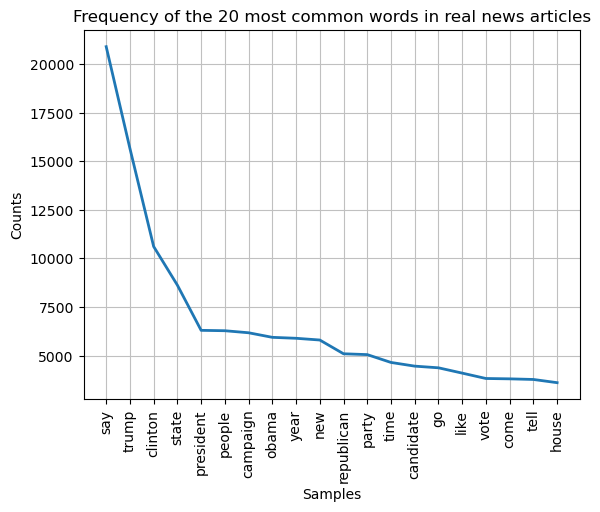

In [21]:
dist_real.plot(20, title='Frequency of the 20 most common words in real news articles');

In [22]:
dist_fake = FreqDist(lem_text_fake)
dist_fake

FreqDist({'clinton': 6749, 'trump': 6686, 'people': 5480, 'say': 5450, 'hillary': 4544, 'state': 4100, 'year': 4072, 'election': 3593, 'time': 3589, 'new': 3528, ...})

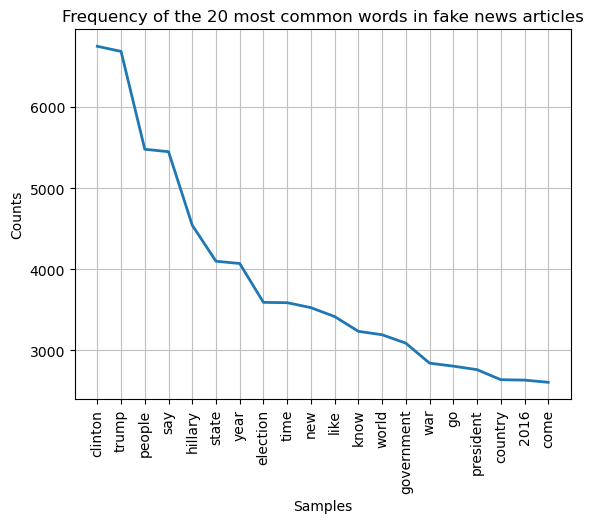

In [23]:
dist_fake.plot(20, title='Frequency of the 20 most common words in fake news articles');

* Create word clouds for each of the article types, real and fake (2 total word clouds)
  * Use the joined lemmatized text

real news cloud

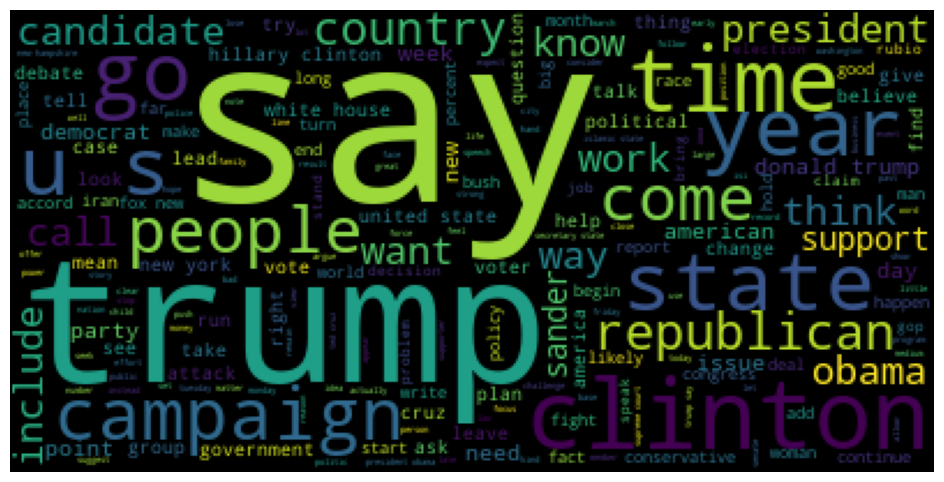

In [24]:
cloud_real = WordCloud(random_state = 123).generate(' '.join(lem_text_real))

plt.figure(figsize = (12, 6))
plt.imshow(cloud_real);
plt.axis('off');

fake news cloud

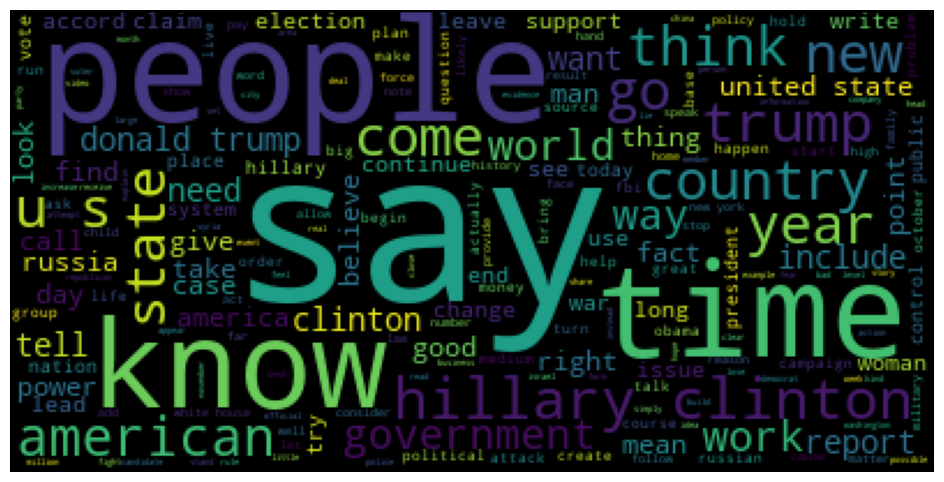

In [25]:
cloud_fake = WordCloud(random_state = 123).generate(' '.join(lem_text_fake))

plt.figure(figsize = (12, 6))
plt.imshow(cloud_fake);
plt.axis('off');

save processed df

In [26]:
import os

if not os.path.exists('data/fake-real-news-data-clean.csv'):
  df.to_csv('data/fake-real-news-data-clean.csv')

# W1-C2: Text Classification

In [34]:
df.head()

,title,text,label,tokenized_text,lemmatized_text,joined_lemmatized_text,length
0,A whirlwind day in D.C. showcases Trump’s unor...,Donald Trump endorsed an unabashedly noninterv...,REAL,"[donald, trump, endorsed, an, unabashedly, non...","[donald, trump, endorse, unabashedly, noninter...",donald trump endorse unabashedly noninterventi...,1763
1,"In Baltimore's call for federal police probe, ...",While some Justice Department investigations a...,REAL,"[while, some, justice, department, investigati...","[justice, department, investigation, adversari...",justice department investigation adversarial n...,1278
2,Trump Proudly Declares: Most Of The People I’v...,Trump Proudly Declares: Most Of The People I’v...,FAKE,"[trump, proudly, declares, :, most, of, the, p...","[trump, proudly, declare, people, insult, dese...",trump proudly declare people insult deserved a...,490
3,Inside the Trump-Bush melodrama: Decades of te...,Donald Trump spent a day in January 2014 hobno...,REAL,"[donald, trump, spent, a, day, in, january, 20...","[donald, trump, spend, day, january, 2014, hob...",donald trump spend day january 2014 hobnob pol...,2480
4,Shutdown clash to return in force by December,Notable names include Ray Washburne (Commerce)...,REAL,"[notable, names, include, ray, washburne, (, c...","[notable, name, include, ray, washburne, comme...",notable name include ray washburne commerce da...,26


## Prepare imports and functions

imports

In [40]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud
# import spacy
# ^^ already imported ^^

import seaborn as sns
from nltk.probability import FreqDist

from sklearn import set_config
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

pd.set_option('display.max_colwidth', 300)
set_config(transform_output='pandas')

Add a function to evaluate a classification model. You can use the one from the Learn Platform.

In [61]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict


In [62]:
## Function to convert string lists back to lists

# def convert_to_list(string):
#     """Remove braces, split tokens on commas, and then strip quotes from outside of each token"""
#     new_list = [token.strip("' ") for token in string.strip("[]").split(',')]
#     return new_list

## Prepare the Data

In [ ]:
# ## applymap function to convert string lists back to lists.

# cols = ['tokens','no_stops','no_stops_no_punct','spacy_lemmas'] #, 'bigrams']
# df[cols] = df[cols].applymap(convert_to_list)
# df.info()

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6306 entries, 0 to 6334
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   title                   6306 non-null   object
 1   text                    6306 non-null   object
 2   label                   6306 non-null   object
 3   tokenized_text          6306 non-null   object
 4   lemmatized_text         6306 non-null   object
 5   joined_lemmatized_text  6306 non-null   object
 6   length                  6306 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 394.1+ KB


In [64]:
df.head()

,title,text,label,tokenized_text,lemmatized_text,joined_lemmatized_text,length
0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. military presence in Asia.\n\nThe foreign policy pos...",REAL,"[donald, trump, endorsed, an, unabashedly, noninterventionist, approach, to, world, affairs, monday, during, a, day, -, long, tour, of, washington, ,, casting, doubt, on, the, need, for, the, north, atlantic, treaty, organization, and, expressing, skepticism, about, a, muscular, u.s., military, ...","[donald, trump, endorse, unabashedly, noninterventionist, approach, world, affair, monday, day, long, tour, washington, cast, doubt, need, north, atlantic, treaty, organization, express, skepticism, muscular, u.s., military, presence, asia, foreign, policy, position, outline, meeting, editorial,...",donald trump endorse unabashedly noninterventionist approach world affair monday day long tour washington cast doubt need north atlantic treaty organization express skepticism muscular u.s. military presence asia foreign policy position outline meeting editorial board washington post come day tr...,1763
1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimore Mayor Stephanie Rawlings-Blake put in a 911 cal...",REAL,"[while, some, justice, department, investigations, are, adversarial, ,, a, new, model, of, collaborative, reform, is, surprising, police, in, some, cities, ,, as, , they, find, themselves, included, as, part, of, the, solution, ., \n\n, searching, for, a, "", framework, ..., [, to, ], heal, ,, ""...","[justice, department, investigation, adversarial, new, model, collaborative, reform, surprising, police, city, find, include, solution, search, framework, heal, baltimore, mayor, stephanie, rawlings, blake, 911, department, justice, ask, civil, right, investigation, baltimore, police, department...",justice department investigation adversarial new model collaborative reform surprising police city find include solution search framework heal baltimore mayor stephanie rawlings blake 911 department justice ask civil right investigation baltimore police department beat cop tactic week local pros...,1278
2,Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It,"Trump Proudly Declares: Most Of The People I’ve Insulted Deserved It By Andrew Bradford on October 27, 2016 Subscribe \nArrogance is defined as “an insulting way of thinking or behaving that comes from believing that you are better, smarter, or more important than other people.” In other words, ...",FAKE,"[trump, proudly, declares, :, most, of, the, people, i, ’ve, insulted, deserved, it, by, andrew, bradford, on, october, 27, ,, 2016, subscribe, \n, arrogance, is, defined, as, “, an, insulting, way, of, thinking, or, behaving, that, comes, from, believing, that, you, are, better, ,, smarter, ,, ...","[trump, proudly, declare, people, insult, deserved, andrew, bradford, october, 27, 2016, subscribe, arrogance, define, insulting, way, thinking, behave, come, believe, well, smart, important, people, word, donald, trump, perfectly, exemplify, arrogance, prove, fact, appear, good, morning, americ...",trump proudly declare people insult deserved andrew bradford october 27 2016 subscribe arrogance define insulting way thinking behave come believe well smart important people word donald trump perfectly exemplify arrogance prove fact appear good morning america thursday morning gop nominee readi...,490
3,Inside the Trump-Bush melodrama: De

X and y variables

In [37]:
X = df['joined_lemmatized_text']
y = df['label']

X.shape, y.shape

((6306,), (6306,))

train/test split

In [74]:
## Split data into train, test, val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42)
(len(X_train), len(X_val), len(X_test))

(4414, 946, 946)

In [75]:
# Check class balance
y_train.value_counts(normalize=True)

FAKE    0.507023
REAL    0.492977
Name: label, dtype: float64

create a pipeline and a model

In [83]:
countvector = CountVectorizer()
nbayes = MultinomialNB()

count_vect_pipe = Pipeline([('vectorizer', countvector),
                      ('clf', nbayes)]);
count_vect_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('clf', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.96      0.92      0.94      2238
        REAL       0.92      0.96      0.94      2176

    accuracy                           0.94      4414
   macro avg       0.94      0.94      0.94      4414
weighted avg       0.94      0.94      0.94      4414



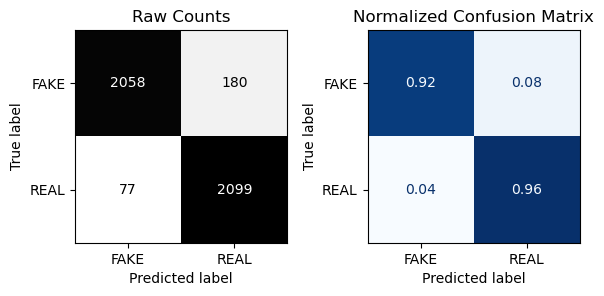


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        FAKE       0.93      0.87      0.90       476
        REAL       0.87      0.93      0.90       470

    accuracy                           0.90       946
   macro avg       0.90      0.90      0.90       946
weighted avg       0.90      0.90      0.90       946



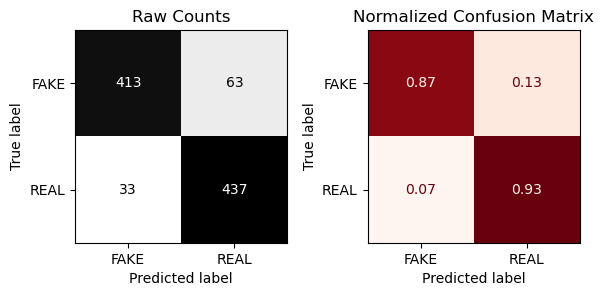

In [80]:
evaluate_classification(count_vect_pipe, X_train, y_train, X_test, y_test)

define param grids

In [95]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english'],
    'vectorizer__ngram_range': [(1, 1), (1, 2)]
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]
vect_params_combined

[{'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)]},
 {'vectorizer': [TfidfVectorizer()],
  'vectorizer__norm': ['l1', 'l2'],
  'vectorizer__use_idf': [True, False],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)]}]

gridsearch pipeline

In [89]:
gs_pipe = Pipeline([('vectorizer',CountVectorizer()),
                    ('clf',MultinomialNB())])
gs_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()), ('clf', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'clf__force_alpha': 'warn'}

fit gridsearch

In [90]:
%%time
# Create grid search
grid_search = GridSearchCV(gs_pipe, vect_params_combined, cv=3, verbose=1, n_jobs=-1)
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_


Fitting 3 folds for each of 540 candidates, totalling 1620 fits


CPU times: total: 2min 3s
Wall time: 56min 29s


{'vectorizer': CountVectorizer(max_df=0.7, min_df=4, ngram_range=(1, 2), stop_words='english'),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 4,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__stop_words': 'english'}

In [94]:
# Define parameters to tune multiple models

param_grid_RF = {
    'clf' : [RandomForestClassifier(random_state = 42)],
    'clf__max_depth' : [5, None],
    'clf__min_samples_leaf' : [1, 2],
}

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}

param_grid_logreg = {
    'clf': [LogisticRegression(random_state = 42)],
    'clf__C' : [.1, 1, 10, 100],
}

# combine into list of params
model_params_combined = [param_grid_RF, param_grid_MNB, param_grid_logreg]

In [97]:
import itertools

paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
paired_param_grids[0]

({'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)]},
 {'clf': [RandomForestClassifier(random_state=42)],
  'clf__max_depth': [5, None],
  'clf__min_samples_leaf': [1, 2]})

In [98]:
final_params = []
for vector_params, model_params in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]

{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.7, 0.8, 0.9],
 'vectorizer__min_df': [2, 3, 4],
 'vectorizer__max_features': [None, 1000, 2000],
 'vectorizer__stop_words': [None, 'english'],
 'vectorizer__ngram_range': [(1, 1), (1, 2)],
 'clf': [RandomForestClassifier(random_state=42)],
 'clf__max_depth': [5, None],
 'clf__min_samples_leaf': [1, 2]}

In [92]:
# save grid search to a file
import joblib
joblib.dump(grid_search, 'grid_search.pkl')

grid_search

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'vectorizer': [CountVectorizer(max_df=0.7, min_df=4,
                                                         ngram_range=(1, 2),
                                                         stop_words='english')],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__ngram_range'..., 2)],
                          'vectorizer__stop_words': [None, 'english']},
                         {'vectorizer': [TfidfVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__ngram_range': [(1, 1), (1, 2)],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__stop_words': [None, 'english'],
                          'vectorizer__use_idf': [True, False]}],
             verbose=1)

In [99]:
%%time
# Create grid search
grid_search2 = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1, n_jobs=-1)
    
# Fit the model
grid_search2.fit(X_train, y_train)

Fitting 3 folds for each of 5400 candidates, totalling 16200 fits


In [ ]:
evaluate_classification(grid_search2, X_train, y_train, X_test, y_test)

### next

In [33]:
# play a sound when the code is done
import os
os.system('echo -ne "\007"')

0